##  **Import Library dan data Preprocessing**




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# import streamlit as st

from itertools import chain
from sklearn.model_selection import train_test_split
from numba import jit 
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Concatenate, Multiply, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default Perangkat GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("Tidak memakai GPU")
    
print("Versi Tensorflow: {}".format(tf.__version__))

Tidak memakai GPU
Versi Tensorflow: 2.7.0


## **Content-based feature engineering**

In [5]:
snack_df = pd.read_csv("../snacks_data.csv")
snack_df.head(10)

,food_id,food_name,type_of_food,food_genre
0,32281,Strawberry and orange muffins,Cakes,"vegan,healthy"
1,5114,Garlic and aubergine bread,Bread Products,vegan
2,28977,Avocado and cucumber panini,Bread Products,"vegan,healthy"
3,9253,Peppercorn and chilli gyoza,International,vegan
4,9969,Courgette and prune buns,Bread Products,vegan
5,32935,Kiwi fruit sorbet with black pepper sauce,Yogurt,"vegan,healthy"
6,11061,Black pepper and tahini bagel,Bread Products,vegan
7,820,Lemon and cardamom biscuits,Cookies/Biscuits,vegan
8,15335,Strawberry and thyme vegancrepes,Crepes,vegan
9,15417,Spinach and squash gyoza,International,vegan


In [6]:
snack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   food_id       12294 non-null  int64 
 1   food_name     12294 non-null  object
 2   type_of_food  12294 non-null  object
 3   food_genre    12294 non-null  object
dtypes: int64(1), object(3)
memory usage: 384.3+ KB


In [7]:
#shape of the dataset
snack_df.shape

(12294, 4)

In [8]:
snack_df.columns

Index(['food_id', 'food_name', 'type_of_food', 'food_genre'], dtype='object')

In [9]:
snack_df['type_of_food'].unique()

array(['Cakes', 'Bread Products', 'International ', 'Yogurt ',
       'Cookies/Biscuits', 'Crepes', 'Jams', 'Candy', 'Chips',
       'Chocolates', 'Protien Bars', 'Energy Bars'], dtype=object)

In [10]:
type_initial = snack_df['type_of_food'].map(lambda x: x.split(',')).values.tolist()
all_food_types = list(set(chain(*type_initial)))
#all_food_types

In [11]:
snack_df['food_name'].unique()

array(['Strawberry and orange muffins', 'Garlic and aubergine bread',
       'Avocado and cucumber panini', ..., 'Stephens, Griffith and Jones',
       'Kidd PLC', 'Holland PLC'], dtype=object)

In [12]:
#all_food_genres
genre_initial = snack_df['food_genre'].map(lambda x: x.replace(" ", "").split(',')).values.tolist()
all_food_genres = list(set(chain(*genre_initial)))


In [13]:
def invert_dict(d):
    return {value: key for key, value in d.items()}

all_food_genres = sorted(list(all_food_genres)) #Mengonversi menjadi list agar dapat diurutkan berdasarkan abjad
ngenres = len(all_food_genres)

idx2genre = dict(enumerate(all_food_genres)) # Membuat Dictionary pemetaan dari indeks ke dict
genre2idx = invert_dict(idx2genre) # Inverse dict

genre2idx

{'almonds': 0,
 'artificialflavours': 1,
 'baked': 2,
 'bitter': 3,
 'caramel': 4,
 'cheese': 5,
 'chocolate': 6,
 'darkchocolate': 7,
 'extradark': 8,
 'fried': 9,
 'frozenfood': 10,
 'fruitflavours': 11,
 'glutenfree': 12,
 'healthy': 13,
 'nonvegetarian': 14,
 'salty': 15,
 'spicy': 16,
 'sweet': 17,
 'vegan': 18,
 'vegetarian': 19,
 'waffer': 20}

In [14]:
all_food_types = sorted(list(all_food_types)) # Mengkonversi menjadi list agar dapat diurutkan berdasarkan abjad
ntypes = len(all_food_types)

idx2type = dict(enumerate(all_food_types)) # Membuat Dictionary pemetaan dari indeks ke dict
type2idx = invert_dict(idx2type) # Inverse dict

type2idx

{'Bread Products': 0,
 'Cakes': 1,
 'Candy': 2,
 'Chips': 3,
 'Chocolates': 4,
 'Cookies/Biscuits': 5,
 'Crepes': 6,
 'Energy Bars': 7,
 'International ': 8,
 'Jams': 9,
 'Protien Bars': 10,
 'Yogurt ': 11}

In [15]:
# Copy kolomnya
snack_df['features_food_genre'] = snack_df['food_genre']

# Mengubah None menjada string kosong
snack_df['features_food_genre'] = snack_df['features_food_genre'].fillna('') 

# Memisah genres menjadi list string
snack_df['features_food_genre'] = snack_df['features_food_genre'].map(lambda x: x.replace(" ", "").split(','))

snack_df['features_food_genre']

0                                         [vegan, healthy]
1                                                  [vegan]
2                                         [vegan, healthy]
3                                                  [vegan]
4                                                  [vegan]
                               ...                        
12289    [vegetarian, sweet, artificialflavours, gluten...
12290              [vegetarian, sweet, artificialflavours]
12291              [vegetarian, sweet, artificialflavours]
12292    [vegetarian, sweet, artificialflavours, gluten...
12293              [vegetarian, sweet, artificialflavours]
Name: features_food_genre, Length: 12294, dtype: object

In [16]:
#Encode genres food
def encode_genres(genres):
    out = np.zeros(ngenres)
    for genre in genres:
        if genre == '':
            pass
        else:
            out[genre2idx[genre]] = 1
    return out.tolist()

snack_df['features_food_genre'] = snack_df['features_food_genre'].map(encode_genres)
snack_df['features_food_genre'] 

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
12289    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12290    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12291    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12292    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12293    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: features_food_genre, Length: 12294, dtype: object

In [17]:
# Kopi kolomnya
snack_df['features_food_type'] = snack_df['type_of_food']

# Mengubah None menjadi string kosong
snack_df['features_food_type'] = snack_df['features_food_type'].fillna('') 

# Memisah genres menjadi list string
snack_df['features_food_type'] = snack_df['features_food_type'].map(lambda x: x.split(','))

snack_df['features_food_type']

0                 [Cakes]
1        [Bread Products]
2        [Bread Products]
3        [International ]
4        [Bread Products]
               ...       
12289             [Candy]
12290             [Candy]
12291             [Candy]
12292             [Candy]
12293             [Candy]
Name: features_food_type, Length: 12294, dtype: object

In [18]:
# Encode type food
#@st.cache
def encode_type(types):
    out = np.zeros(ntypes)
    for type in types:
        if type == '':
            pass
        else:
            out[type2idx[type]] = 1
    return out.tolist()

snack_df['features_food_type'] = snack_df['features_food_type'].map(encode_type)
snack_df['features_food_type'] 

0        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
4        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
12289    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12290    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12291    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12292    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
12293    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: features_food_type, Length: 12294, dtype: object


## **Collaborative-filtering feature engineering**


In [19]:
# Cek struktur data
rating = pd.read_csv("../rating_snacks.csv")
rating.head(10)

,user_id,food_id,rating
0,8177,2890,8
1,2642,5277,8
2,1729,10321,-1
3,8382,228,7
4,8270,4038,9
5,3896,14345,5
6,6971,2926,8
7,8308,195,8
8,6237,264,8
9,661,13863,8


In [20]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   user_id  1048575 non-null  int64
 1   food_id  1048575 non-null  int64
 2   rating   1048575 non-null  int64
dtypes: int64(3)
memory usage: 24.0 MB


In [21]:
rating.columns

Index(['user_id', 'food_id', 'rating'], dtype='object')

In [22]:
rating.loc[rating['user_id'] == 1]

,user_id,food_id,rating
20694,1,3455,-1
30861,1,9062,-1
47570,1,30296,-1
48638,1,10209,-1
49994,1,11266,-1
...,...,...,...
1008795,1,1836,-1
1025254,1,9750,-1
1030415,1,936,-1
1044040,1,27899,-1


### Menurunkan jumlah users untuk eksplorasi & pelatihan yang lebih cepat


In [23]:
rating = rating[rating['food_id'].isin(snack_df['food_id'])] 

In [24]:
rating

,user_id,food_id,rating
0,8177,2890,8
1,2642,5277,8
2,1729,10321,-1
3,8382,228,7
4,8270,4038,9
...,...,...,...
1048570,2278,72,-1
1048571,8039,5258,10
1048572,7502,2866,3
1048573,7802,1117,4


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating'>

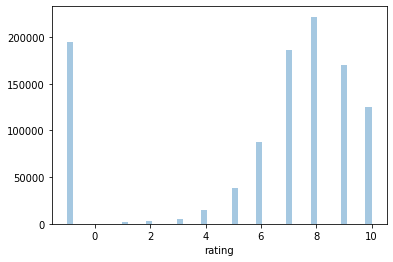

In [25]:
rating['rating'].replace({-1: np.nan}).dropna().describe()
sb.distplot(rating['rating'], kde = False)

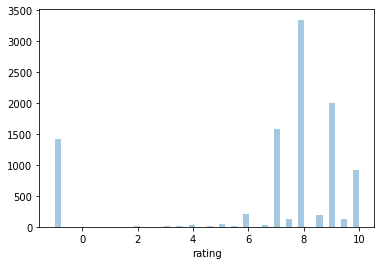

In [26]:
user_median = rating.groupby('user_id').median()['rating']
sb.distplot(user_median, kde = False);
overall_median = user_median.median()
user_median = dict(user_median.replace({-1 : overall_median}))

In [27]:
user_medians = rating['user_id'].apply(lambda x: user_median[x])
rating['rating'] = rating['rating'].replace({-1 : np.nan}).fillna(user_medians)
rating['rating'] = rating['rating'] / rating['rating'].max() # Normalisasi dengan membagi yang terbesar

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


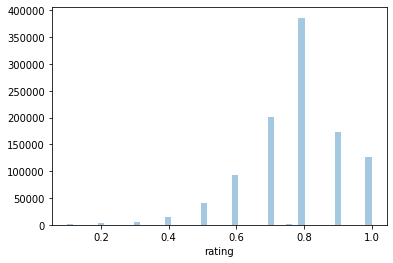

In [28]:
# Histogram
sb.distplot(rating['rating'], kde = False);

In [29]:
num_neg = 4
user2n_snack = dict(rating.groupby('user_id').count()['food_id'])

In [30]:
#unique user ids
all_users = np.sort(rating['user_id'].unique())
#unique food ids
all_snacks = np.sort(rating['food_id'].unique())
n_snacks = len(all_snacks)
n_users = len(all_users)

@jit
def choice_w_exclusions(array, exclude, samples):
    max_samples = len(array)-len(exclude)
    final_samples = min(samples, max_samples)
    possible = np.array(list(set(array) - set(exclude)))
    np.random.seed(0)
    return np.random.choice(possible, size = final_samples, replace = False)
@jit
def flat(l):
    return [item for sublist in l for item in sublist]

## Sample negative entries

In [31]:
neg_user_id = []
neg_snack_id = []
neg_rating = []

for user in all_users:
    #Pengecualian food ids untuk user id spesifik
    exclude = list(rating[rating['user_id'] == user]['food_id'])
    sampled_snack_id = choice_w_exclusions(all_snacks, exclude, len(exclude) * num_neg)
    
    neg_user_id.append([user] * len(sampled_snack_id))
    neg_snack_id.append(sampled_snack_id)
    neg_rating.append([0.] * len(sampled_snack_id))
    
neg_user_id = flat(neg_user_id)
neg_snack_id = flat(neg_snack_id)
neg_rating = flat(neg_rating)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'exclude' of function 'choice_w_exclusions'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\user\AppData\Local\Temp\ipykernel_6316\3743642666.py", line 8:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'l' of function 'flat'.

In [32]:
negatives = pd.DataFrame({'user_id': neg_user_id,
                          'food_id': neg_snack_id,
                          'rating': neg_rating})
data = pd.concat([rating, negatives], ignore_index = True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5238631 entries, 0 to 5238630
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   food_id  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 119.9 MB


In [34]:
snack_df['features'] = snack_df['features_food_genre'] + snack_df['features_food_type']
snack_df['features'] = snack_df['features'].apply(np.array)

n_feats = len(snack_df['features'].iloc[0])

data = data.join(snack_df['features'], on = 'food_id').dropna()

In [35]:
data

,user_id,food_id,rating,features
0,8177,2890,0.8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2642,5277,0.8,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1729,10321,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,8382,228,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,8270,4038,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
5238625,10093,434,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5238626,10093,943,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5238628,10093,2508,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5238629,10093,12231,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [36]:
n_feats

33

In [37]:
#Membuat dictionary untuk menghubungkan snack id ke item id
snack2item_dict = dict(zip(np.sort(all_snacks), list(range(n_snacks))))
item2snack_dict = {v: k for k, v in snack2item_dict.items()}

def snack2item(s_id):
    return snack2item_dict[s_id]

def item2snack(i_id):
    return item2snack_dict[i_id]
                       
data['item_id'] = data['food_id'].apply(snack2item)

In [38]:
data.head()

,user_id,food_id,rating,features,item_id
0,8177,2890,0.8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2574
1,2642,5277,0.8,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3872
2,1729,10321,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5394
3,8382,228,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",203
4,8270,4038,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3325


In [39]:
data.shape

(3689455, 5)

In [40]:
x0 = data['user_id'].to_numpy()
x1 =data['item_id'].to_numpy()
x2 = np.stack(data['features'].to_numpy())
y = data['rating'].to_numpy()

(x0_train, x0_val,
 x1_train, x1_val,
 x2_train, x2_val,
 y_train, y_val) = train_test_split(x0, x1, x2, y,
                                    test_size = 0.1,
                                    random_state = 42)


x_train = [x0_train, x1_train, x2_train]
x_val = [x0_val, x1_val, x2_val]

In [41]:
x_train

[array([3375, 1275, 5529, ..., 5287, 6747, 5254], dtype=int64),
 array([3730, 5091, 2231, ...,   87,  234,  244], dtype=int64),
 array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])]

In [42]:
x_val

[array([8883, 2755, 7013, ..., 4869, 6889, 9000], dtype=int64),
 array([4366, 3335, 3516, ..., 3161, 5637, 4657], dtype=int64),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

'''
Implementasi model
> [Sangat berdasarkan [Neural Collaborative Filtering paper repo](https://github.com/hexiangnan/neural_collaborative_filtering)]

Namun, model kami meningkatkan model referensi dengan menyertakan informasi fitur makanan ringan!
'''

## **Membangun Model Neural Matric Factorization (NeuMF)**

In [43]:
def get_model(num_users, num_items, num_item_feats, mf_dim, layers = [64, 32, 16, 8]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    feats_input = Input(shape=(num_item_feats,), dtype='float32', name = 'feats_input')

    # User&Item Embeddings for Matrix Factorization
    MF_Embedding_User = Embedding(input_dim = num_users+1, output_dim = mf_dim,
                                  name = 'user_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    MF_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = mf_dim,
                                  name = 'item_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    
    # User&Item Embeddings for MLP part
    MLP_Embedding_User = Embedding(input_dim = num_users+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_user',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1)
    MLP_Embedding_Item = Embedding(input_dim = num_items+1, output_dim = int(layers[0] / 2),
                                   name = 'mlp_embedding_item',
                                   embeddings_initializer = RandomNormal(stddev=0.001),
                                   input_length = 1) 
    
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part with item features
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent, feats_input])
    for l in layers:
        layer = Dense(l, activation='relu')
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation = 'sigmoid',
                       kernel_initializer = 'lecun_uniform',
                       name = 'prediction')(predict_vector)
    
    model = Model(inputs = [user_input, item_input, feats_input], outputs = prediction)
    return model

In [44]:
learning_rate = 0.001
batch_size = 256
n_epochs = 3
mf_dim = 15
layers = [128,64, 32, 16, 8]

In [45]:
model = get_model(n_users, n_snacks, n_feats, mf_dim, layers)
model.compile(optimizer = Adam(lr = learning_rate), loss = 'mean_squared_logarithmic_error')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:
hist = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val),
                 batch_size = batch_size, epochs = n_epochs, verbose = True, shuffle = True)

Epoch 1/3
12971/12971 [==============================] - 167s 13ms/step - loss: 0.0270 - val_loss: 0.0233
Epoch 2/3
12971/12971 [==============================] - 171s 13ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 3/3
12971/12971 [==============================] - 171s 13ms/step - loss: 0.0188 - val_loss: 0.0209


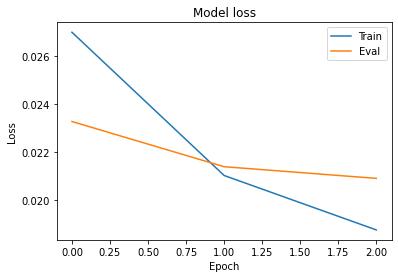

In [47]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.show()


## **Menyimpan model dengan format HDF5 ke folder static**

In [50]:
# Menyimpan model dengan format HDF5 ke folder static
model.save("../static/model.h5")
